# Non-linear Regression

In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:

# Importing prepared dataset
import pickle
input = open('data_reg.pkl', 'rb')
obj = pickle.load(input)
input.close()
X_train = obj["X_train"]
X_test = obj["X_test"]
y_train = obj["y_train"]
y_test = obj["y_test"]

* загрузка данных, которые были "законсервированы" ранее

In [3]:
# Metrics
def metrics(X_train, X_test, y_train, y_test, y_pred, model):
    RMSE = [mean_squared_error(y_train, model.predict(X_train),squared=False), mean_squared_error(y_test, y_pred, squared=False)]
    R2 = [model.score(X_train, y_train), model.score(X_test, y_test)]
    results = {'RMSE': RMSE, 'R2':R2}
    return pd.DataFrame(results, index=['Train', 'Test'])

* создана функция чтобы одновременно вычислять соответствующие метрики.

In [4]:
f = ['is_urban','age','female','married','religion','can_calc_percents','employment_type_last_year','income_government_last_year','num_times_borrowed_last_year','active_bank_user','cash_property_savings','has_insurance','can_call','can_make_transaction','phone_ownership','has_investment','num_financial_activities_last_year','literacy']

* переменная f содержит в себе наиболее значимые предикторы.

# Regression Tree

In [5]:
def max_leaf_nodes(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        dt = DecisionTreeRegressor(max_leaf_nodes = i, random_state=10).fit(X_train, y_train)
        mse_train.append(mean_squared_error(y_train, dt.predict(X_train)))
        mse_test.append(mean_squared_error(y_test, dt.predict(X_test)))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='blue', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='red', label='test')
    ax.set_ylabel("MSE")
    ax.set_xlabel("max_leaf_nodes")

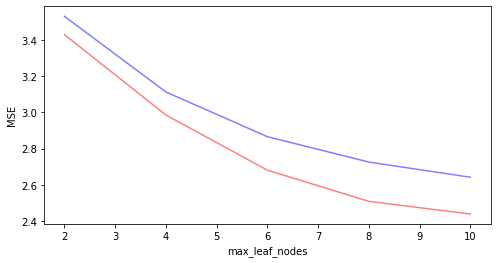

In [6]:
# The optimal number of max_leaf_nodes
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
max_leaf_nodes(X_train[f], X_test[f], y_train, y_test, [2, 4, 6, 8, 10])

* функция, которая позволяет строить множество деревьев и визуализировать их показатели. График показывает зависиомсть MSE от глубины самого дерева.

In [21]:

# Fitting Tree to the Training set
dt = DecisionTreeRegressor(max_leaf_nodes = 9).fit(X_train[f], y_train)

# Predicting the Test set results
dt_y_pred = dt.predict(X_test[f])

# Metrics
metrics(X_train[f], X_test[f], y_train, y_test, dt_y_pred, dt).round(2)

,RMSE,R2
Train,1.64,0.33
Test,1.57,0.38


* экспериментальным путем было выявлено, что оптимальная глубина дерева = 9. При этом R^2 33% на обучающей выборке и  38% на тестовой. Модель не переобучена. Однако все также качество модели остается не на высоком уровне.

Text(0.5, 1.0, 'Tree. Feature Importance')

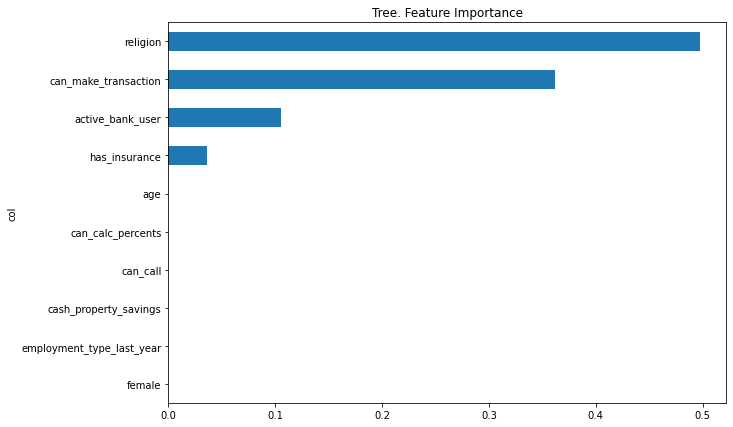

In [22]:
# Features importances
dt_imp = pd.DataFrame({'imp': dt.feature_importances_, 'col': X_train[f].columns})
dt_imp = dt_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-10:]
dt_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('Tree. Feature Importance')

* делаем вывод, что только 4 переменные были значимы при построении дерева. Наибольшее влияния при этом оказывает religion и can_make_transaction (напомним, что эта переменная имеет наибольшее влияния на У).  Однако для нашего исследования эта переменная не имеют сильного влияния, поскольку не показывает уровень экономического состояния, а логично предположить, что в соответствующей стране преобладает определенная религия. Такм образом нужно отобрать те, которые будут интерпретируемы для результатов. Последующие 2 предиктора на прямую связаны с экономической сферой и могут влиять на благосостояние человека. Поэтому по сути поставленной задачи переменные can_make_transaction и active_bank_user наиболее влиятельны и напрямую не связаны со странами (по данной переменной сложно выявить тип страны, нежели по религии).

# Random Forest

In [9]:
def rf_best_n_estimator(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        rf = RandomForestRegressor(n_estimators=i, random_state=10).fit(X_train, y_train)
        mse_train.append(mean_squared_error(y_train, rf.predict(X_train)))
        mse_test.append(mean_squared_error(y_test, rf.predict(X_test)))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='blue', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='red', label='test')
    ax.set_ylabel("MSE")
    ax.set_xlabel("N_estimators")

* в этом методе следует учесть, как количество деревьев, так их и сложность. Далее определим наилучшее число деревьев.

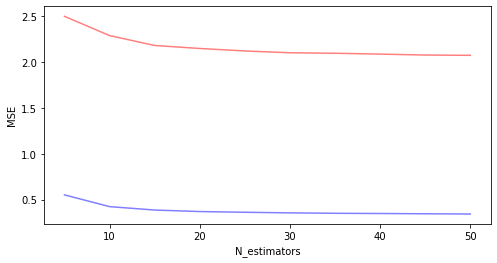

In [10]:
# The optimal number of trees 
from sklearn.ensemble import RandomForestRegressor    
rf_best_n_estimator(X_train[f], X_test[f], y_train, y_test, [5, 10, 15, 20, 25, 30, 35, 40, 45, 50])

* при любом чилсле деревьев от 5 до 50 - ошибка тестирования сильно преувеличивает ошибку обучения. Модель будет переобучна в любом случае. Минимум ошибки тестирования - примерно при 15 деревьях.

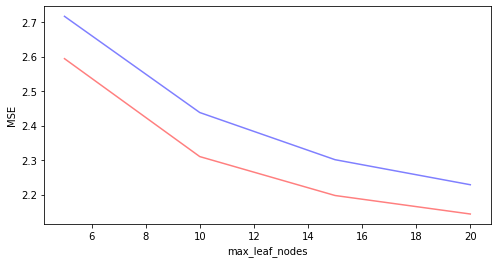

In [11]:
def rf_max_leaf_nodes(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        rf = RandomForestRegressor(n_estimators=15, max_leaf_nodes =i, random_state=10).fit(X_train, y_train)
        mse_train.append(mean_squared_error(y_train, rf.predict(X_train)))
        mse_test.append(mean_squared_error(y_test, rf.predict(X_test)))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='blue', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='red', label='test')
    ax.set_ylabel("MSE")
    ax.set_xlabel("max_leaf_nodes")
    
# The optimal number of max_leaf_nodes
rf_max_leaf_nodes(X_train[f], X_test[f], y_train, y_test, [5, 10, 15, 20])

In [12]:
# Fitting Random Forest to the Training set
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 15, max_leaf_nodes = 19, random_state = 10).fit(X_train[f], y_train)

# Predicting the Test set results
rf_y_pred = rf.predict(X_test[f])

# Metrics
metrics(X_train[f], X_test[f], y_train, y_test, rf_y_pred, rf).round(2)

,RMSE,R2
Train,1.50,0.44
Test,1.47,0.46


По графику видно, что минимальная разница между тестовой и обучающей выборкой начинается после глубины дерева = 15. Экспериментальным путем вычислено, что наиболее оптимально выбрать 19.
При этом мы получили максимальное значение R^2 среди всех моделей, переобучение не произошло. Делаем вывод, что модель улучшилась.

Text(0.5, 1.0, 'Random Forest. Feature Importance')

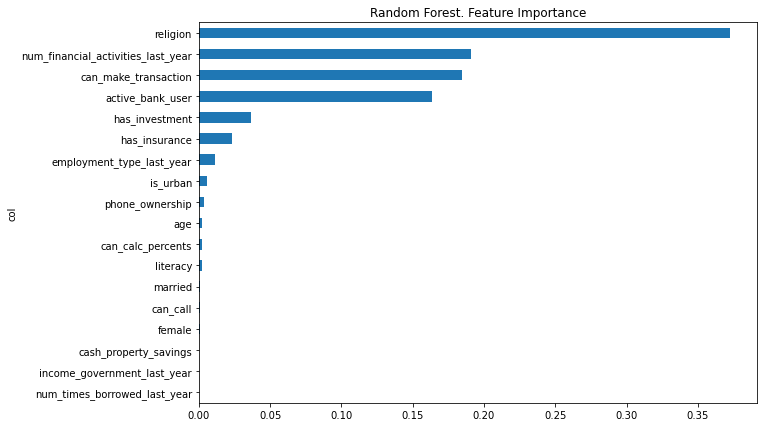

In [13]:

# Features importances
rf_imp = pd.DataFrame({'imp': rf.feature_importances_, 'col': X_train[f].columns})
rf_imp = rf_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-20:]
rf_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('Random Forest. Feature Importance')

* для данной модели большее число переменных стало значимо. Так же наибольшее влияние имеет religion, однако существенными стали таки переменные, как is_urban, age, literacy... То есть данный метод расширил число предикторов, что способствует улучшению качества модели.
Однако, исходя из предыдущих рассуждений - по этой модели делаем вывод, что на экономическое состояние страны с точки зрения интерпретации переменных имеют num_financial_activities_last_year и 2 переменные из прошлой модели (can_make_transaction и active_bank_user).

# CatBoost

* данный метод рекомендуется использовать в случаях, если датасет содержит большое количество категориальных переменных. Как раз такой случай наблюдается в моем датасете.

In [14]:
#! pip install catboost

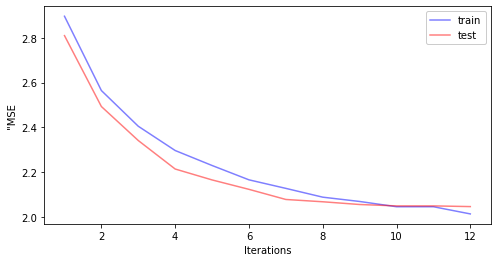

In [15]:
def catboost_best_n_estimator(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        catboost = CatBoostRegressor(iterations=i,random_state=10,eval_metric='RMSE',loss_function='RMSE').fit(X_train, y_train,eval_set=(X_test, y_test),logging_level='Silent')
        mse_train.append(mean_squared_error(y_train, catboost.predict(X_train)))
        mse_test.append(mean_squared_error(y_test, catboost.predict(X_test)))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='blue', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='red', label='test')
    ax.set_ylabel('"MSE')
    ax.set_xlabel('Iterations')
    ax.legend(framealpha=1, frameon=True);
    
from catboost import CatBoostRegressor
catboost_best_n_estimator(X_train[f], X_test[f], y_train, y_test, list(range(1,13)))

* При значении количества итераций 10 значения на тестовой и обучающей выборке совпадают. При 9 и 11 они также особо не отличаются. Однако, экспериментальным путем выбираем 10. 

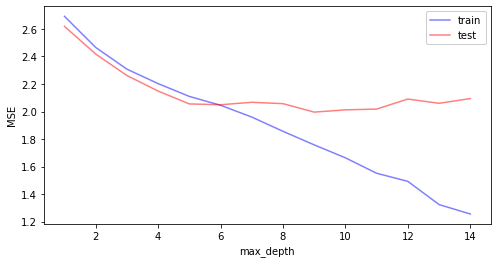

In [23]:

def catboost_max_depth(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        catboost = CatBoostRegressor(iterations=10,max_depth=i,random_state=10,eval_metric='RMSE',loss_function='RMSE').fit(X_train,y_train,eval_set=(X_test, y_test),logging_level='Silent')
        mse_train.append(mean_squared_error(y_train, catboost.predict(X_train)))
        mse_test.append(mean_squared_error(y_test, catboost.predict(X_test)))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='blue', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='red', label='test')
    ax.set_ylabel("MSE")
    ax.set_xlabel("max_depth")
    ax.legend(framealpha=1, frameon=True);

catboost_max_depth(X_train[f], X_test[f], y_train, y_test, list(range(1,15)))

In [29]:
# Fitting CatBoost to the Training set
cb = CatBoostRegressor(iterations=7,max_depth=9,random_state=10,eval_metric='RMSE',loss_function='RMSE').fit(X_train[f], y_train,eval_set=(X_test[f], y_test),logging_level='Silent')

# Predicting the Test set results
cb_y_pred = cb.predict(X_test[f])

# Metrics
metrics(X_train[f], X_test[f], y_train, y_test, cb_y_pred, cb).round(2)

,RMSE,R2
Train,1.36,0.54
Test,1.43,0.49


* Снова проэкспериментировав с глубиной дерева, выбираем 9. Модель улучшилась. Значение MSE на тестовой немного больше, однако данные сопоставимы. Нам удалось добиться значения R^2 = 0.54 (на тестовой) и 0.49 (на обучающей). 

Text(0.5, 1.0, 'Boosting. Feature Importance')

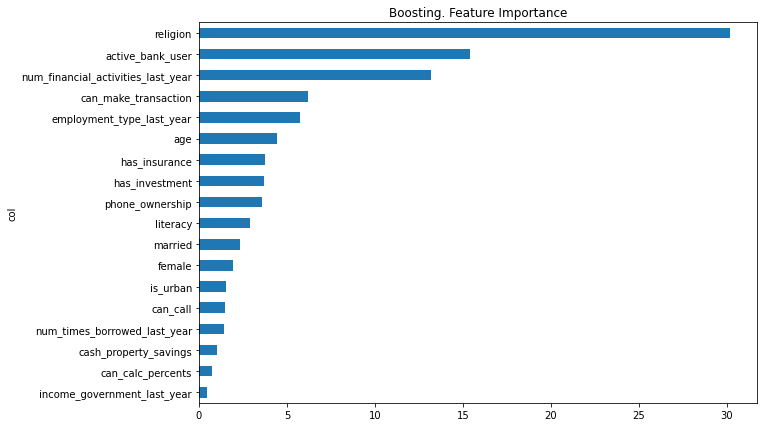

In [30]:
# Features importances
cb_imp = pd.DataFrame({'imp': cb.get_feature_importance(), 'col': X_train[f].columns})
cb_imp = cb_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-25:]
cb_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('Boosting. Feature Importance')

* все переменные, добавленные в модель стали значимы. Аналогично предыдущему исселодованию - наиболее значимы такие же предикторы.

# RESULTS

In [32]:
# Metrics
metric_dt = metrics(X_train[f], X_test[f], y_train,y_test, dt_y_pred, dt).round(2).abs()
metric_dt['Type'] = 'Tree'

metric_rf = metrics(X_train[f], X_test[f], y_train,y_test,  rf_y_pred, rf).round(2).abs()
metric_rf['Type'] = 'Random forest'

metric_cb = metrics(X_train[f], X_test[f], y_train,y_test, cb_y_pred, cb).round(2)
metric_cb['Type'] = 'Catboost'

metric = pd.concat([metric_dt,metric_rf,metric_cb])
metric

,RMSE,R2,Type
Train,1.64,0.33,Tree
Test,1.57,0.38,Tree
Train,1.50,0.44,Random forest
Test,1.47,0.46,Random forest
Train,1.36,0.54,Catboost
Test,1.43,0.49,Catboost


* Можно сделать вывод, что метод CatBoost наилучшим образом справился с поставленной задачей. Поскольку изначально датасет содержал в себе 59 переменных, а в модель добавлено только 28 из них - качество не на самом высшем уровне. Что подтверждает эксперименты, проведенные с моделью. Так, изначально выборка содержала 22 переменные (R^2 макс. при этом был 0,403), 26 переменных (R^2 = 0,48) и теперешняя модель, где был достигнут максимальный результат. Исходя из этого можно сделать вывод, что на исходной выборке можно построить модель с высоким качеством, однако при данном обьеме информации по этому датасету - будут сложности с интерпретацией и выводами. А по данным исследованиям выявлено, что наилучшими предикторами для социально-экономического положения страны будут can_make_transaction и active_bank_user.

* Дополнительно был проведен эксперимент с построением модели CatBoost со всеми исходными качественными переменными (это можно наблюдать в дополнтиельном файле)